# HW5: Topic Models and LDA


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Spring, 2021._

---

**Name:** Jake Taylor

**Names of any collaborators:** _Names here_

*Due: 11:59pm Monday, May 10, 2021 via GradeScope*

---

Recall the following generatize model for LDA. Suppose we have $K$ topics and $N$ documents.

For each topic $k \leq K$, draw a topic 
$$\eta_k \sim \text{Dir}(\phi)$$

Then, for each document $n \leq N$, draw topic proportions 
$$\pi_n \sim \text{Dir}(\alpha)$$

Finally, for each word $l$ in document $n$, first draw a topic assignment 
$$
z_{n,l} \mid \pi_n \sim \text{Cat}(\pi_n)
$$
and draw a word
$$
x_{n,l} \mid z_{n,l} \sim \text{Cat}(z_{n,l})
$$

As mentioned in class, while this formulation is easier to present, it's more efficient to represent the documents as sparse vectors of _word counts_, $\mathbf{y}_n \in \mathbb{N}^V$ where $y_{n,v} = \sum_{l=1}^L \mathbb{I}[x_{n,l} = v]$. 

In this assignment, we will be re-exploring the Federalist papers in their entirety. We've provided a $N \times V$ dataframe of the essays represented as word counts. The rows of the data frame correspond to the 85 individual essays and the columns correspond to the 5320 words in the vocabulary. We have already preprocessed the raw essays to remove very common and very infrequent words.

Using this data, we will fit a topic model and do some analysis.

In [80]:
import pandas as pd 

# Load the data
data = pd.read_csv('tokenized_fed.csv', index_col = 0)
data

,unequivocal,experience,inefficacy,subsisting,federal,called,deliberate,new,constitution,united,america,subject,speaks,importance,comprehending,consequences,existence,union,safety,welfare,parts,composed,fate,empire,many,respects,interesting,world,frequently,remarked,seems,reserved,people,country,conduct,example,decide,important,question,whether,...,undivided,reposing,dilatory,agreements,servant,nice,canvassed,collectively,understanding,lucrative,probity,converse,deducible,judicature,reservations,arisen,liquidate,bench,altered,convicted,conjectured,esteemed,evasion,litigation,ordain,imitated,syllable,judicatures,agreeably,suit,chancery,jurisprudence,reexamination,writ,commonlaw,intent,refutation,habeas,corpus,clerks
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,7.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,7.0,1.0,2.0,1.0,1.0,1.0,2.0,5.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,3.0,7.0,3.0,0.0,2.0,0.0,2.0,1.0,8.0,1.0,0.0,1.0,3.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,21.0,6.0,0.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,4.0,6.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,7.0,3.0,1.0,0.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,5.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,3.0,0.0,0.0,0.0,7.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.0,0.0,0.0,0.0,6.0,1.0,1.0,8.0,12.0,8.0,0.0,6.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
81,0.0,0.0,0.0,0.0,12.0,0.0,0.0,2.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
82,0.0,1.0,0.0,0.0,7.0,2.0,2.0,9.0,13.0,6.0,0.0,9.0,0.0,1.0,0.0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,7.0,1.0,1.0,0.0,5.0,2.0,2.0,1.0,1.0,1.0
83,0.0,0.0,0.0,0.0,2.0,1.0,0.0,9.0,26.0,12.0,2.0,7.0,0.0,3.0,1.0,0.0,0.0,5.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,10.0,2.0,4.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,3.0,1.0


## Problem 1: Fit LDA on this data set.

Fit a 10 topic LDA on the data using CAVI. For each topic, output the top 5 words. You might find the structure in the [Poisson matrix factorization notebook](https://github.com/slinderman/stats271sp2021/blob/main/notebooks/Lap_5_Poisson_MF.ipynb) helpful. (Note that that notebook used the JAX backend available in the `tfp-nightly` package, but you could have used the regular [TensorFlow Probability](tensorflow.org/probability/api_docs/python/tfp) package instead. The nice thing about TFP is that its functions broadcast nicely, which is helpful when we have lots of factors in the mean field variational posterior.

In [2]:
!pip install tfp-nightly

     |████████████████████████████████| 5.4MB 2.8MB/s 


In [3]:
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange

from jax import jit
import jax.numpy as np
import jax.scipy.special as spsp
import jax.random as jr

import tensorflow_probability as tfp
import tensorflow_probability.substrates.jax.distributions as tfd

In [4]:
y_nv = data.to_numpy()

In [177]:
class LDA:
  """Implmentation of LDA."""
  def __init__(self, data, K=10, alpha=1, phi=1):
    assert isinstance(data, np.ndarray)
    self.y_nv = data.astype(np.float32)
    self.N, self.V = self.y_nv.shape
    self.K = K
    self.alpha = alpha
    self.phi = phi
    
    onp.random.seed(123)
    self.q_pi = tfd.Dirichlet(self.alpha * onp.random.rand(self.N, self.K).astype(np.float32))
    self.q_eta = tfd.Dirichlet(self.phi * onp.random.rand(self.K, self.V).astype(np.float32))

    self.q_z = tfd.Multinomial(self.y_nv, logits=onp.zeros((self.N, self.V, self.K)).astype(np.float32))

    self.q_pi_prior = tfd.Dirichlet(self.alpha * onp.ones((self.N, self.K)).astype(np.float32))
    self.q_eta_prior = tfd.Dirichlet(self.phi * onp.ones((self.K, self.V)).astype(np.float32))

    self.E_z = self.q_z.mean()
    self.E_log_pi = self.expected_log_dirichlet(self.q_pi)
    self.E_log_eta = self.expected_log_dirichlet(self.q_eta)
    self.log_lambda_z_nvk = self.E_log_pi[:, None, :] + self.E_log_eta.T

  @staticmethod
  def expected_log_dirichlet(dirichlet):
    """Helper function."""
    alpha = dirichlet.concentration
    return spsp.digamma(alpha) - spsp.digamma(alpha.sum(axis=1)[...,None])

  def cavi_step(self):
    """One step of CAVI."""
    self.E_log_pi = self.expected_log_dirichlet(self.q_pi)
    self.E_log_eta = self.expected_log_dirichlet(self.q_eta)
    assert self.E_log_pi.shape == (self.N, self.K)
    assert self.E_log_eta.shape == (self.K, self.V)

    self.log_lambda_z_nvk = self.E_log_pi[:, None, :] + self.E_log_eta.T
    assert self.log_lambda_z_nvk.shape == (self.N, self.V, self.K)

    self.q_z = tfd.Multinomial(self.y_nv, logits=self.log_lambda_z_nvk, name='topic_assignments')
    self.E_z = self.q_z.mean()
    assert self.E_z.shape == (self.N, self.V, self.K)
    
    self.E_N_nk = self.E_z.sum(axis=1)
    self.E_N_kv = self.E_z.sum(axis=0).T
    assert self.E_N_nk.shape == (self.N, self.K)
    assert self.E_N_kv.shape == (self.K, self.V)

    self.q_pi = tfd.Dirichlet(self.alpha + self.E_N_nk, name='topic_proportions')
    self.q_eta = tfd.Dirichlet(self.phi + self.E_N_kv, name='topic_parameters')

  def elbo(self, array_return=False):
    """Compute the evidence lower bound."""
    elbo = []
    elbo.append(-self.q_pi.kl_divergence(self.q_pi_prior).sum())
    elbo.append(-self.q_eta.kl_divergence(self.q_eta_prior).sum())
    elbo.append(np.multiply(self.E_log_pi[:, None, :], self.E_z).sum())
    elbo.append(np.multiply(self.E_log_eta.T[None, :, :], self.E_z).sum())
    elbo.append(-np.multiply(np.log(self.q_z.probs_parameter()), self.E_z).sum())
    if array_return:
      return np.array(elbo)
    return np.array(elbo).sum() / (self.y_nv.sum())
  
  def cavi(self, num_iters=100):
    """Run coordinate ascent VI for LDA."""
    elbos = [self.elbo()]
    for itr in trange(num_iters):
        self.cavi_step()
        elbos.append(self.elbo())
        
    return np.array(elbos), (self.q_z, self.q_pi, self.q_eta)

In [186]:
test = LDA(y_nv, alpha=.1, phi=.1)
test.elbo(array_return=True)

DeviceArray([   -15591.806,   -670901.56 , -13227881.   ,  -8146686.   ,
                172065.84 ], dtype=float32)

In [187]:
res = test.cavi(num_iters=100)

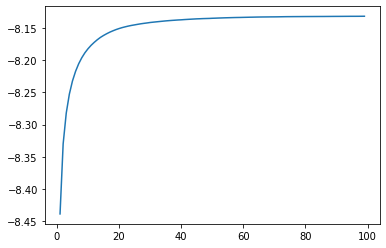

In [188]:
plt.plot(res[0][1:])
plt.show()

In [386]:
top5 = res[1][2].mean().argsort(axis=1)[...,-5:].copy()

In [387]:
data.columns[top5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


array([['necessary', 'jury', 'union', 'cases', 'laws'],
       ['men', 'constitution', 'national', 'union', 'people'],
       ['representatives', 'great', 'people', 'courts', 'federal'],
       ['time', 'nations', 'citizens', 'public', 'man'],
       ['representatives', 'convention', 'legislative', 'constitution',
        'people'],
       ['number', 'great', 'new', 'powers', 'union'],
       ['legislative', 'senate', 'powers', 'number', 'executive'],
       ['governments', 'without', 'national', 'either', 'us'],
       ['law', 'nature', 'new', 'even', 'constitution'],
       ['nations', 'war', 'general', 'authority', 'national']],
      dtype=object)

## Problem 2: Analysis/Exploration

Using the model, for each essay assign it the most likely topic. For the undisputed papers, plot the histogram of this topic usage vs author.

In [388]:
#load authorship
authorship = pd.read_csv('authorship.csv', index_col = 0)
authorship.columns = ['author']
top_topics = np.argmax(res[1][1].mean().copy(), axis=1)
top_topics
authorship['topic'] = top_topics
counts = authorship.value_counts().to_frame('counts').reset_index()

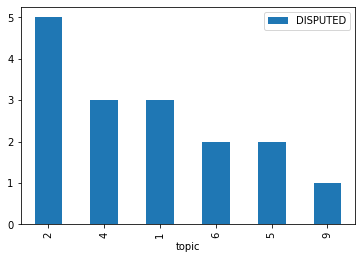

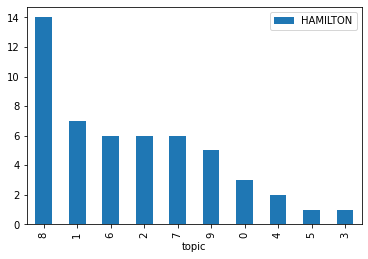

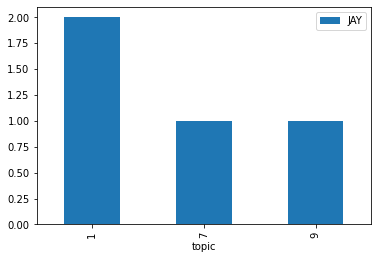

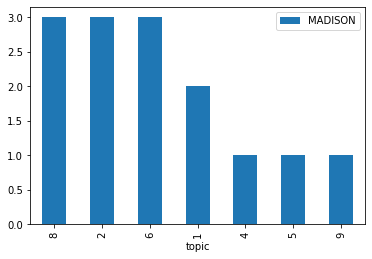

In [389]:
for label, grp in counts.groupby('author'):
    grp.plot.bar(x='topic', y='counts', label = label)

## Problem 3: Short Answer questions

### Part a)

Explain what approach you would take if you wanted to use LDA to help settle disputed authorship. How would you incorporate authorship by different authors into your model?



If you knew the author of each document in the training set, you could take the learned distribution over the topics for each author and compare new literature to these topic distributions. You could use a distance metric to grade the 'closeness' of the new document's topic proportions and then learned topic proportions from the training set.

### Part b)

A shortcoming of LDA discussed in this class is the fact that the model is exchangeable (which is not a very reasonable assumption for essays). What would you do to address this shortcoming? In essence, how could you account for dependencies between words that are near each other in the essay?

You could take a Probabilistic Graphical Model approach and add dependencies (edges) between word nodes. Then, you would solve for a set of parameters that are local to that word that capture small scale dependencies (i.e. markov blanket of the word). This would better account for dependencies and not make the exchangability assumption in LDA.

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw5_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 
